In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df = df.rename(columns={'conversion': 'target'})
df = df.rename(columns={'offer': 'treatment'})

In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
df['treatment'] = df['treatment'].replace(['Buy One Get One', 'Discount'], 1)
df['treatment'] = df['treatment'].replace(['No Offer'], 0)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], test_size=0.3, random_state=0)
indices_learn, indices_test = train_test_split(df.index, test_size=0.3, random_state=123)

In [8]:
#!pip install category_encoders
import category_encoders as ce
ce.TargetEncoder(smoothing=0).fit_transform(df.zip_code,df.target)
ce.TargetEncoder(smoothing=0).fit_transform(df.channel,df.target)

,channel
0,0.127155
1,0.159407
2,0.159407
3,0.159407
4,0.159407
...,...
63995,0.159407
63996,0.127155
63997,0.127155
63998,0.171734


In [9]:
#!pip install scikit-uplift==0.2.0

In [10]:
#!pip install catboost

In [11]:
cat_features = ['zip_code', 'channel']
treat_train = df.loc[indices_learn, 'treatment']
treat_test =  df.loc[indices_test, 'treatment']
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [23]:
cat_features

['zip_code', 'channel']

uplift@30%: -0.0074


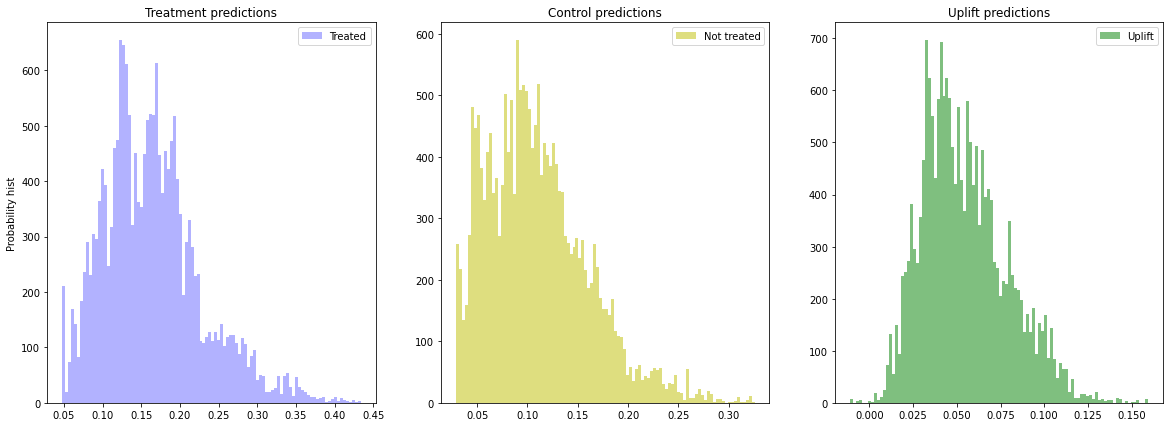

In [13]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [14]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.366084
1,treatment,17.495478
2,used_bogo,11.898511
3,recency,11.279151
4,zip_code,11.131189
5,history,10.507691
6,used_discount,9.119917
7,channel,7.201978


In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)


<ipython-input-15-ce11d222af87>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [16]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

#plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

C:\Users\igora\anaconda3\lib\site-packages\sklift\models\models.py:389: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_ctrl, y_ctrl = X[treatment == 0], y[treatment == 0]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [17]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,-0.007377
1,ClassTransformation,-0.009167
